In [83]:

from datasets import load_dataset

dataset = load_dataset("yuntian-deng/im2latex-100k")

In [361]:
import torchvision.transforms.functional as vF
from PIL import Image


def to_binary_tensor(im):
    im = im.convert('L')
    im = Image.eval(im, lambda x: 255 if x > 150 else 0)
    im = im.convert('1')
    im = vF.pil_to_tensor(im).squeeze_(0).logical_not_()

    return im

In [362]:

Segment = tuple[torch.Tensor, int, int, int, int]

def get_infector(im: torch.Tensor):
    infected = torch.zeros(im.shape)

    def bfs_infect(i, j, component = []):
        if infected[i, j]:
            return None

        infected[i, j] = 1
        component.append([i,j])
    
        neightbours = [(i, j+1),  (i-1, j+1), (i-1, j), (i-1, j-1), (i, j-1), (i+1, j-1), (i+1, j), (i+1, j+1) ]
        neightbours = filter(lambda x: (0 <= x[0] <= im.shape[0] ) and (0 <= x[1] <= im.shape[1]), neightbours)

        for nbr in neightbours:
            if not infected[nbr[0], nbr[1]] and im[nbr[0],nbr[1]]:
                bfs_infect(nbr[0],nbr[1], component)

        return component

    return bfs_infect, infected

def get_segment(im: torch.Tensor, component: list[tuple[int, int]]) -> Segment:
    min_i = min(component, key=lambda x: x[0])[0]
    min_j = min( component, key=lambda x: x[1])[1]
    max_i = max( component, key=lambda x: x[0])[0]
    max_j = max( component, key=lambda x: x[1])[1]

    component_im = torch.full((3, max_i-min_i +1, max_j-min_j + 1), 255, dtype=torch.uint8) 
    to_local = lambda x: [x[0] -min_i, x[1] -min_j]
    #local_comp = list(map(lambda x: [x[0] -min_i, x[1] -min_j], component))
    for i,j in component:
        li, lj = to_local([i,j])
        component_im[:, li,lj] = im[:, i,j]
    

    return [component_im, min_i, max_i, min_j, max_j]
    
def segmentate(im: torch.Tensor) -> list[Segment]:
    original_im = vF.pil_to_tensor(im)
    im = to_binary_tensor(im)
    bfs_infect, infected = get_infector(im)
    
    components = []
    for j in range(im.shape[1]):
        for i in range(im.shape[0]):
            if infected[i,j] == 0 and True == im[i, j]:
                component = bfs_infect(i, j, [])
                components.append(component)

    return list(map(lambda x: get_segment(original_im, x) , components))



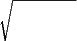

In [363]:
import matplotlib.pyplot as plt

for im in dataset['train'][0:50]['image']:
    segments = segmentate(im)

    for seg in segments:
        im = vF.to_pil_image(seg[0])
        im.show()

        

# plt.show()


# formulae tokenizaiton

In [364]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))

In [365]:
from tokenizers.trainers import BpeTrainer
trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])

In [366]:
from tokenizers.pre_tokenizers import Whitespace
tokenizer.pre_tokenizer = Whitespace()

In [367]:
#tokenizer.train_from_iterator(dataset['train']['formula'], trainer)

#tokenizer.save('tokenizer.json')

tokenizer = Tokenizer.from_file("tokenizer.json")

In [368]:
tokenizer.encode('[CLS] q w e r t y u i o p a s d f g h j k l z x c v b n m o p qwertyuioplkjhgfdsazxcvbnm absdaskdjb { \mathrm { h o p f } } \simeq \sum _ { n > 0 } \widetilde { G }').tokens

['[CLS]',
 'q',
 'w',
 'e',
 'r',
 't',
 'y',
 'u',
 'i',
 'o',
 'p',
 'a',
 's',
 'd',
 'f',
 'g',
 'h',
 'j',
 'k',
 'l',
 'z',
 'x',
 'c',
 'v',
 'b',
 'n',
 'm',
 'o',
 'p',
 'q',
 'w',
 'e',
 'rt',
 'y',
 'u',
 'i',
 'op',
 'l',
 'k',
 'j',
 'h',
 'g',
 'f',
 'ds',
 'a',
 'z',
 'x',
 'c',
 'v',
 'b',
 'n',
 'm',
 'ab',
 's',
 'da',
 's',
 'k',
 'd',
 'j',
 'b',
 '{',
 '\\',
 'mathrm',
 '{',
 'h',
 'o',
 'p',
 'f',
 '}',
 '}',
 '\\',
 'simeq',
 '\\',
 'sum',
 '_',
 '{',
 'n',
 '>',
 '0',
 '}',
 '\\',
 'widetilde',
 '{',
 'G',
 '}']

In [39]:
print(tokenizer.token_to_id('[CLS]'))

1


# Encoder #2 (for processing entire image)

In [369]:
from einops import rearrange, repeat

NHEAD = 6
NUM_LAYERS = 12
DEFAULT_D_MODEL = 384 
DEFAULT_PATCH_SIZE = 8

class ViTEncoderEntireIm(nn.Module):
    def __init__(
        self,
        *,
        d_model = DEFAULT_D_MODEL,
        patch_size = DEFAULT_PATCH_SIZE,
        dropout=0.,
        emb_dropout=0.,
        width = 320,
        height = 64,
        batch_first = True
    ):
        super().__init__()
        assert width % patch_size == 0 and height % patch_size == 0, 'image dimensions should be divisible by the patch size'

        self.channels = 3
        self.patch_size = patch_size
        self.max_width = width
        self.max_height = height

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=12, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=12)
        
        num_patches = (width // patch_size)*(height // patch_size)
        patch_dim = self.channels * patch_size ** 2

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, d_model))
        self.patch_to_embedding = nn.Linear(patch_dim, d_model)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.dropout = nn.Dropout(emb_dropout)

        self.norm = nn.LayerNorm(d_model)

    def forward(self, img):
        p = self.patch_size

        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)
        x = self.patch_to_embedding(x.float())
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        h, w = torch.tensor(img.shape[2:])//p
        pos_emb_ind = repeat(torch.arange(h)*(self.max_width//p-w), 'h -> (h w)', w=w)+torch.arange(h*w)
        pos_emb_ind = torch.cat((torch.zeros(1), pos_emb_ind+1), dim=0).long()
        x += self.pos_embedding[:, pos_emb_ind]
        x = self.dropout(x)

        x = self.encoder(x)
        x = self.norm(x)

        return x

In [370]:
img = dataset['train'][0:1]['image'][0]

vitBigIm = ViTEncoderEntireIm()
out = vitBigIm(vF.pil_to_tensor(img).unsqueeze_(0))
out.shape

torch.Size([1, 321, 384])

# Segment images preprocessing

In [371]:
import numpy as np
from matplotlib import pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

SEG_IM_HEIGHT = 64
SEG_IM_WIDTH = 64

In [372]:
from einops import rearrange
from albumentations.pytorch import ToTensorV2

def normalize_segment(seg: Segment) -> torch.Tensor:
    im = seg[0]
    im = rearrange(im, 'c h w -> h w c') # for albumentations
    im = np.array(im)

    transforms = []
    if im.shape[1] > 64:
        transforms.append(A.Resize(
        height=400,
        width=200, 
        interpolation=1,
        always_apply=False, 
    ))
    transforms.append(A.PadIfNeeded(
        min_height=SEG_IM_HEIGHT, 
        min_width=SEG_IM_WIDTH,  
        position= 'top_left',  # Union[albumentations.augmentations.geometric.transforms.PadIfNeeded.PositionType, str]
        value=[255,255,255],
    ))
    transforms.append(ToTensorV2())

    transform = A.Compose(transforms)
    augmented_im = transform(image=im)['image']
    
    return [augmented_im, seg[1], seg[2], seg[3], seg[4]]

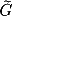

In [373]:
segments = segmentate(dataset['train'][0]['image'])
seg = segments[9]

tsr = normalize_segment(seg)[0]

vF.to_pil_image(tsr).show()

# Encoder #1 (for segments)

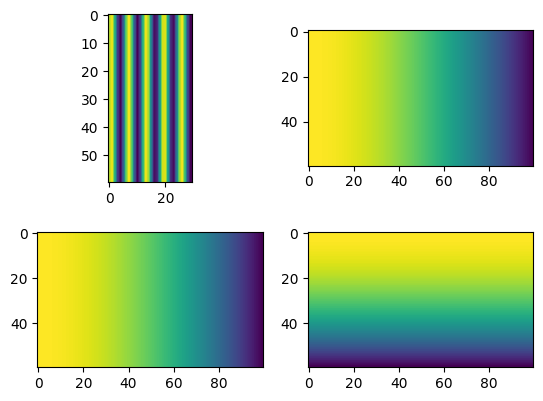

In [374]:
import  math
def positionalencoding2d(d_model, height, width):
# Ref: https://github.com/wzlxjtu/PositionalEncoding2D/blob/master/positionalembedding2d.py

    if d_model % 4 != 0:
        raise ValueError("Cannot use sin/cos positional encoding with "
                         "odd dimension (got dim={:d})".format(d_model))
    pe = torch.zeros(d_model, height, width)
    # Each dimension use half of d_model
    d_model = int(d_model / 2)
    div_term = torch.exp(torch.arange(0., d_model, 2) *
                         -(math.log(10000.0) / d_model))
    pos_w = torch.arange(0., width).unsqueeze(1)
    pos_h = torch.arange(0., height).unsqueeze(1)
    pe[0:d_model:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
    pe[1:d_model:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
    pe[d_model::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
    pe[d_model + 1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
    
    return pe

pe = positionalencoding2d(512, 60, 100)

plt.subplot(221)
plt.imshow(pe[0,:,70:100])
plt.subplot(222)
plt.imshow(pe[127,:,:])
plt.subplot(223)
plt.imshow(pe[255,:,:])
plt.subplot(224)
plt.imshow(pe[511,:,:])

In [375]:
from einops import rearrange, repeat

NHEAD = 6
NUM_LAYERS = 8
DEFAULT_D_MODEL = 384 
DEFAULT_PATCH_SIZE = 8
MAX_BIG_IM_HEIGHT = 64
MAX_BIG_IM_WIDTH = 320

class ViTEncoderSeg(nn.Module):
    def __init__(
        self,
        *,
        d_model = DEFAULT_D_MODEL,
        patch_size = DEFAULT_PATCH_SIZE,
        dropout=0.,
        emb_dropout=0.,
        width = 64,
        height = 64, 
        batch_first=True
    ):
        super().__init__()
        assert width % patch_size == 0 and height % patch_size == 0, 'image dimensions should be divisible by the patch size'

        self.channels = 3
        self.patch_size = patch_size
        self.max_width = width
        self.max_height = height

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=12, batch_first=batch_first)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=12)
        
        num_patches = (width // patch_size)*(height // patch_size)
        patch_dim = self.channels * patch_size ** 2

        self.pos_embedding = positionalencoding2d(d_model, MAX_BIG_IM_HEIGHT, MAX_BIG_IM_WIDTH)
        self.patch_to_embedding = nn.Linear(patch_dim, d_model)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.dropout = nn.Dropout(emb_dropout)

        self.norm = nn.LayerNorm(d_model)

    def forward(self, segs):
        """
            seg: Tuple of batches
        """
        p = self.patch_size
        miny = segs[1]
        maxy = segs[2]
        minx = segs[3]
        maxx = segs[4]


        x = segs[0]
        
        x = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)
        
        x = self.patch_to_embedding(x.float())
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        

        left_top = rearrange(self.pos_embedding[:, miny, minx], 'd b -> b d').unsqueeze_(1).expand(-1,x.shape[1],-1)
        right_bot = rearrange(self.pos_embedding[:, maxy, maxx], 'd b -> b d').unsqueeze_(1).expand(-1,x.shape[1],-1)

        x[:, ] += left_top + right_bot
        x = self.dropout(x)

        x = self.encoder(x)
        x = self.norm(x)

        return x

In [387]:
segments = segmentate(dataset['train'][0]['image'])

#batchify
segments_mat = [[],[],[],[],[]]
for seg in segments:
    seg = normalize_segment(seg)
    for j, _ in enumerate(seg):
        segments_mat[j].append(seg[j])


segments_mat[0] = torch.stack(segments_mat[0])
for i in range(1,len(segments_mat)):
    segments_mat[i] = torch.tensor(segments_mat[i])

encoder = ViTEncoderSeg()

out = encoder(segments_mat)
out.shape


AttributeError: 'list' object has no attribute 'shape'

# Decoder

In [385]:
import torch.nn as nn
import torch.nn.functional as F

class DecoderLayer(nn.TransformerDecoderLayer):
    def __init__(self, d_model=384, nhead=8, dim_feedforward=2048, dropout=0.1, batch_first=True):
        super(DecoderLayer, self).__init__(d_model, nhead, dim_feedforward, dropout, batch_first=batch_first)
        self.batch_first = batch_first

    def forward(self, tgt, memory1, memory2, tgt_mask=None, memory_mask=None, 
                tgt_key_padding_mask=None, memory_key_padding_mask=None):
        
        multihead_attn1 = nn.MultiheadAttention(d_model, nhead, batch_first=self.batch_first)
        attn1_output, _ = multihead_attn1(tgt, memory1, memory1)
        
        tgt = super(DecoderLayer, self).forward(
            attn1_output, memory2, tgt_mask, memory_mask, tgt_key_padding_mask, memory_key_padding_mask
        )
        
        
        return tgt


class Decoder(nn.TransformerDecoder):
    def __init__(self, decoder_layer, num_layers = 6):
        super(Decoder, self).__init__(decoder_layer, num_layers)
        # Add any additional customizations here

    def forward(self, tgt, memory1, memory2, tgt_mask=None, memory_mask=None,
                tgt_key_padding_mask=None, memory_key_padding_mask=None):
        output = tgt

        for mod in self.layers:
            output = mod(output, memory1, memory2, tgt_mask=tgt_mask, memory_mask=memory_mask,
                         tgt_key_padding_mask=tgt_key_padding_mask,
                         memory_key_padding_mask=memory_key_padding_mask)
            
        return output



In [386]:
d_model = 32
nhead = 8
decoder_layer = DecoderLayer(d_model, nhead)

# Define the decoder using the custom layer
num_layers = 4
decoder = Decoder(decoder_layer, num_layers)

# Example inputs
tgt = torch.rand(20, 1000, d_model)  
memory1 = torch.rand(20, 11, d_model) 
memory2 = torch.rand(20, 12, d_model) 

# Forward pass
output = decoder(tgt, memory1, memory2)
print(output.shape)  


torch.Size([20, 1000, 32])


# Model

In [ ]:
class Model(nn.Module):
    def __init__(
        self,
        *,
        d_model = DEFAULT_D_MODEL
        # TODO
        batch_first = True
    ):
        super().__init__()
        self.encoderSegm_layer = ViTEncoderSeg()
        self.encoderBigIm_layer = ViTEncoderEntireIm()
        decoder_layer = DecoderLayer(d_model = d_model)
        self.decoder = Decoder(decoder_layer)

    def forward(self, batch):
        
        return x